# Importation des modules

In [1]:
# Importation des modules
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from PlotEval import threshold_filter, evaluate_classification, calculate_confidence_levels
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d

# Variables globales
from config import (
    x_test_file,
    y_test_file,
    x_train_file,
    y_train_file,
    classifier_file,
    proba_confident_file
)

# Chargement du trainset, du testset, et du classifier

In [2]:
# x_train contient les caractéristiques des données d'entraînement, y_train contient la variable cible ("win")
x_train, y_train = pd.read_csv(x_train_file), pd.read_csv(y_train_file)["win"]

# x_test contient les caractéristiques des données de test, y_test contient la variable cible ("win")
x_test, y_test = pd.read_csv(x_test_file), pd.read_csv(y_test_file)["win"]

# Chargement du modèle de régression logistique à partir du fichier spécifié
with open(file=classifier_file, mode="rb") as file:
    classifier: LogisticRegression = pk.load(file=file)

# Création des éléments pour l'évaluation

In [3]:
# Concaténation des données d'entraînement et de test pour créer des ensembles complets de caractéristiques (features) et de cibles (reals)
features, reals = pd.concat([x_train, x_test], axis=0).reset_index(drop=True), pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Extraction de la colonne 'elo_diff' de la variable 'features' pour stocker les écarts d'Elo
elo_diffs = features["elo_diff"]

# Utilisation du modèle pré-entraîné pour faire des prédictions sur l'ensemble complet de caractéristiques
preds = classifier.predict(X=features)

# Utilisation du modèle pré-entraîné pour obtenir les probabilités des prédictions positives sur l'ensemble complet de caractéristiques
probas = classifier.predict_proba(X=features)[:, 1]

# Effectuer l'évaluation

,real,prediction,original_proba,adjusted_proba
220,1,-1,0.209476,0.236815
222,1,1,0.724465,0.757361
239,-1,1,0.825069,0.759554
284,1,1,0.760321,0.759497
305,1,1,0.796602,0.763673
...,...,...,...,...
23983,-1,-1,0.303342,0.241489
23984,1,1,0.803190,0.803171
23995,1,1,0.738381,0.753000
23996,-1,-1,0.186066,0.186229


Rapport de classification classifier :

              precision    recall  f1-score   support

          -1       0.80      0.81      0.81 2712.9999999999472
           1       0.81      0.80      0.81    2713.0

    accuracy                           0.81 5425.999999999947
   macro avg       0.81      0.81      0.81 5425.999999999947
weighted avg       0.81      0.81      0.81 5425.999999999947



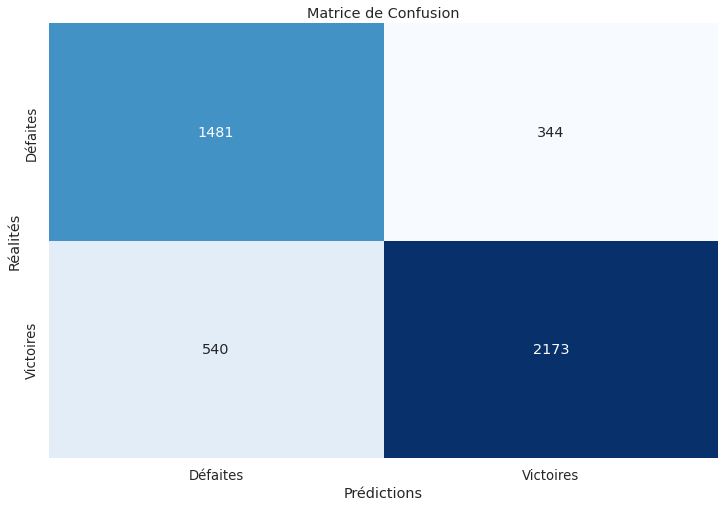

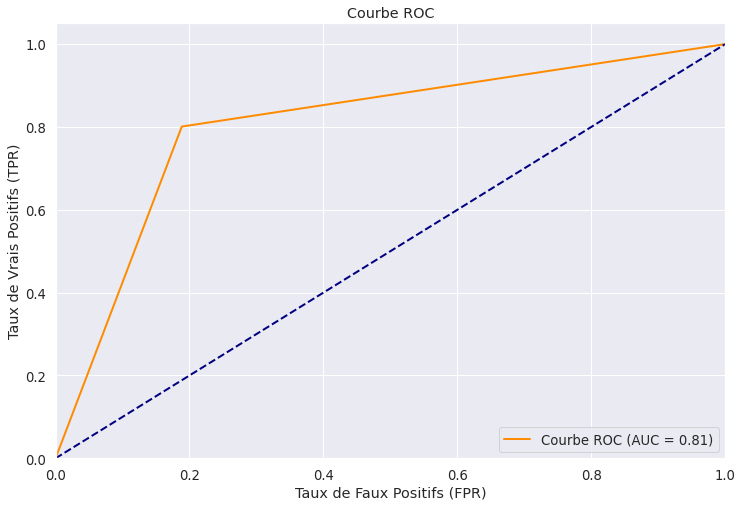

In [4]:
# Définir les seuils d'évaluation
lower_threshold: float = 0.25
upper_threshold: float = 0.75

# Filtrage des prédictions en fonction des seuils spécifiés
df = threshold_filter(
    reals=reals, 
    preds=preds, 
    elo_diffs=elo_diffs, 
    probas=probas, 
    lower_threshold=lower_threshold, 
    upper_threshold=upper_threshold
)

# Affichage du DataFrame résultant du filtrage
display(df)

# Évaluation de la classification en utilisant les résultats du filtrage
evaluate_classification(y_true=df["real"], y_pred=df["prediction"], name_model="classifier")

# Création des éléments pour la fonction d'interpolation

In [5]:
# Définition de la colonne utilisée pour le calcul des niveaux de fiabilité
column: str = "adjusted_proba"

# Définition de l'intervalle entre les niveaux de fiabilité
step: float = 0.05

# Paramètres pour la création du graphique
y_level: float = 0.50
figsize: tuple = (30, 15)
width: float = 0.10

# Filtrage des prédictions pour un seuil spécifié
df = threshold_filter(
    reals=reals,
    preds=preds,
    elo_diffs=elo_diffs,
    probas=probas,
    lower_threshold=0.50,
    upper_threshold=0.50
)

# Calcul des niveaux de fiabilité en utilisant la colonne spécifiée
confidence_levels = calculate_confidence_levels(df=df, column=column, step=step)

# Création d'une liste de tuples contenant les niveaux de fiabilité et la couleur pour le graphique
datas = [(confidence_levels, "green")]

# Affichage des niveaux de fiabilité
for (confidence_levels, labels), color in datas:
    display(confidence_levels)

,proba_class,confidence,count
0,0.00 - 0.05,1.000000,3
1,0.05 - 0.10,0.892857,56
2,0.10 - 0.15,0.782313,294
3,0.15 - 0.20,0.781931,642
4,0.20 - 0.25,0.678363,1026
5,0.25 - 0.30,0.642209,1322
6,0.30 - 0.35,0.604179,1675
7,0.35 - 0.40,0.545889,1885
8,0.40 - 0.45,0.502529,2175
9,0.45 - 0.50,0.429770,2264


# Visualisation de la fiabilité en fonction de la classe de probabilité

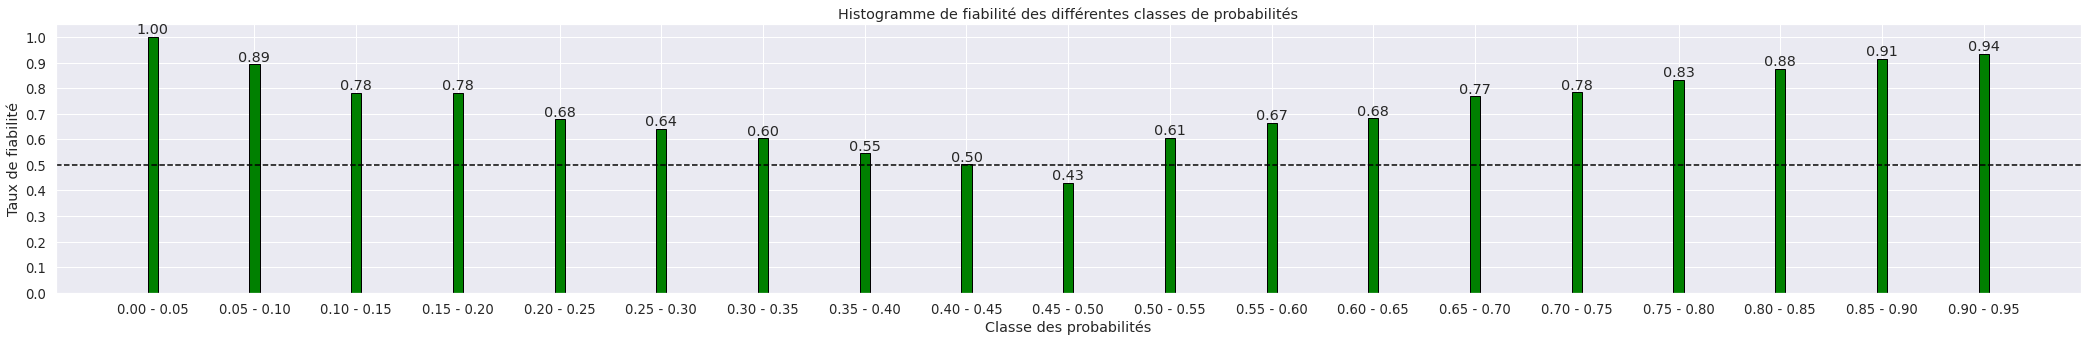

In [6]:
# Création d'une figure
plt.figure(figsize=figsize)

for idx, ((confidence_levels, labels), color) in enumerate(iterable=datas, start=1):
    # Création du subplot
    plt.subplot(3, 1, idx)
    
    # Création du barplot du subplot
    plt.bar(confidence_levels["proba_class"], confidence_levels["confidence"], color=color, edgecolor="black", width=width)
    
    for i, confident in enumerate(confidence_levels["confidence"]):
        # Annoter chaque barre avec la valeur de y
        plt.text(i, confident, f"{confident:.2f}", ha="center", va="bottom")

    # Afficher toutes les "bins"
    plt.xticks(ticks=[i for i in range(0, len(labels))], labels=labels)
    plt.yticks(ticks=np.arange(0, 1.1, 0.1))

    # Ajouter la ligne horizontale
    plt.axhline(y=y_level, color="black", linestyle="--", label=f"Y = {y_level}")

    # Étiquettes et titre
    plt.xlabel("Classe des probabilités")
    plt.ylabel("Taux de fiabilité")
    plt.title("Histogramme de fiabilité des différentes classes de probabilités")

# Affichage des sous-graphiques
plt.tight_layout(pad=3)
plt.show()

# Création de la fonction d'interpolation

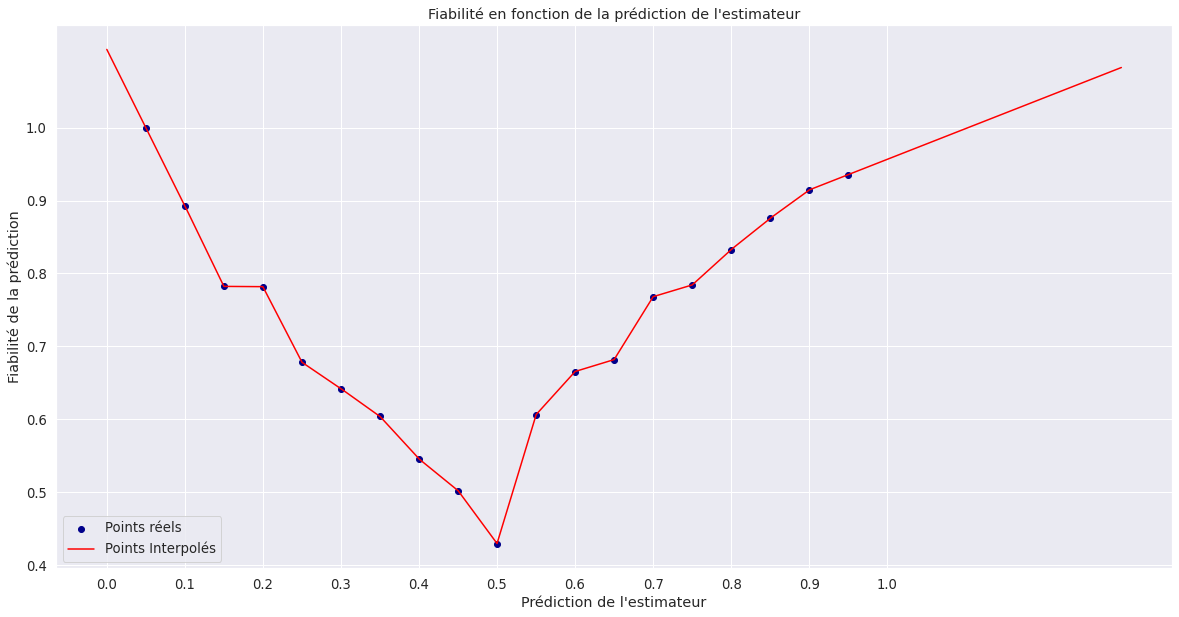

In [9]:
# Récupérer les associations fiabilité en fonction de la classe
proba_confident: pd.DataFrame = datas[0][0][0].copy()
proba_confident["proba_class"] = proba_confident["proba_class"].apply(lambda x: float(x.split(sep=' - ')[1]))
proba_confident = proba_confident[["proba_class", "confidence"]]
proba_confident = {pred_class : proba for pred_class, proba in zip(proba_confident["proba_class"], proba_confident["confidence"])}

# Données pour la création de la fonction d'interpolation
x = list(proba_confident.keys())
y = list(proba_confident.values())

# Création d'une fonction d'interpolation
interpolation_function = interp1d(x, y, kind="slinear", fill_value="extrapolate", bounds_error=False)

# Générez de nouvelles valeurs d'abscisse pour l'interpolation
x_gen = np.linspace(start=0.0, stop=1.30, num=10000)

# Utilisez la fonction d'interpolation pour obtenir de nouvelles valeurs d'ordonnée
y_interp = interpolation_function(x=x_gen)

# Tracez les données originales et l'interpolation
plt.figure(figsize=(20, 10))
plt.scatter(x=x, y=y, label="Points réels", color="darkblue")
plt.plot(x_gen, y_interp, label="Points Interpolés", color="red")
plt.grid(visible=True, which="major")
plt.legend(loc="best")
plt.yticks(ticks=np.arange(0.4, 1.1, 0.1))
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.xlabel("Prédiction de l'estimateur")
plt.ylabel("Fiabilité de la prédiction")
plt.title("Fiabilité en fonction de la prédiction de l'estimateur")
plt.show()

# Sauvegarde de la fonction d'interpolation

In [8]:
# Sauvegarder la fonction d'interpolation dans un fichier
with open(file=proba_confident_file, mode="wb") as file:
    pk.dump(obj=interpolation_function, file=file)